In [ ]:
!unzip /content/Banana_Linux_NoVis.zip

**Project: Navigation DQN**

**1. Start the Environment**

In [23]:
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
import numpy as np

import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# please do not modify the line below
env = UnityEnvironment(file_name="/content/Banana_Linux_NoVis/Banana.x86_64")

**2. Examine the State and Action Spaces**

In [36]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


**3.Defining the Agent, NN and train function**

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F


BUFFER_SIZE = int(1000) # replay buffer size
BATCH_SIZE = 32         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
UPDATE_EVERY = 4        # how often to update the network
LR = 0.0005             # learning rate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DQNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(DQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class Agent:

    def __init__(self, state_size, action_size,learning_rate):

        self.state_size = state_size
        self.action_size = action_size

        self.primary_dqn = DQNetwork(state_size, action_size, 34).to(device)
        self.target_dqn = DQNetwork(state_size, action_size, 34).to(device)

        self.optimizer = optim.Adam(self.primary_dqn.parameters(), lr=learning_rate)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, 34)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0



    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):

        if not isinstance(state, np.ndarray):
          if isinstance(state, (int, float)):  # Assuming state can be a scalar
            state = np.array([state])  # Adjust dimensions as needed
          else:
            raise ValueError("Expected state to be a numpy array or a scalar, got type {}".format(type(state)))

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.primary_dqn.eval()
        with torch.no_grad():
            action_values = self.primary_dqn(state)
        self.primary_dqn.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))


    def learn(self, experiences, gamma):

        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.target_dqn(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.primary_dqn(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.update_target(self.primary_dqn, self.target_dqn, TAU)

    def update_target(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def train(self,n_episodes=1500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
      scores = []                        # list containing scores from each episode
      scores_window = deque(maxlen=100)  # last 100 scores
      eps = eps_start                    # initialize epsilon
      for i_episode in range(1, n_episodes+1):
          env_info = env.reset(train_mode=True)[brain_name]
          state = env_info.vector_observations[0]
          score = 0
          for t in range(max_t):
              ## Get action from agent
              action = self.act(state, eps)

              ## Execute action and get env feedback info
              env_info = env.step(action)[brain_name]

              ## Retriving variables from observation vector
              next_state = env_info.vector_observations[0]   # get the next state
              reward = env_info.rewards[0]                   # get the reward
              done = env_info.local_done[0]

              self.step(state, action, reward, next_state, done)

              state = next_state
              score += reward
              if done:
                  break

          scores_window.append(score)       # save most recent score
          scores.append(score)              # save most recent score
          eps = max(eps_end, eps_decay*eps) # decrease epsilon

          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
          if i_episode % 100 == 0:
              print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
          if np.mean(scores_window)>=13:
              print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
              torch.save(self.primary_dqn.state_dict(), 'model_best.pth')
              break
      return scores

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


**4. Training NN**

In [61]:
agent = Agent(state_size=37, action_size=4, learning_rate=LR)
scores = agent.train(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995)

Episode 100	Average Score: 0.21
Episode 200	Average Score: 2.49
Episode 300	Average Score: 5.47
Episode 400	Average Score: 8.73
Episode 500	Average Score: 10.11
Episode 600	Average Score: 9.84
Episode 700	Average Score: 10.82
Episode 800	Average Score: 11.42
Episode 886	Average Score: 13.00
Environment solved in 786 episodes!	Average Score: 13.00


**5.Plot of Rewards**

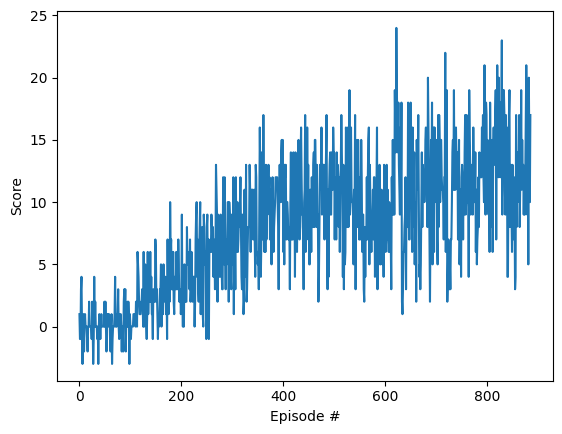

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('training_best.png')
plt.show()

**6.When finished, you can close the environment.**

In [ ]:
env.close()

**Project: Navigation Dueling DQN**

**Ideas for Future Work**

**Defining the Agent, NN and train function**

In [76]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple


BUFFER_SIZE = int(1000) # replay buffer size
BATCH_SIZE = 32         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
UPDATE_EVERY = 4        # how often to update the network
LR = 0.0005             # learning rate

class DuelingDQNetwork(nn.Module):
    """Enhanced Dueling DQN Architecture."""
    def __init__(self, state_size, action_size, seed=34, fc1_units=128, fc2_units=128, fc3_units=64):
        super(DuelingDQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        # Initial Linear layers
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)

        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.bn3 = nn.BatchNorm1d(fc3_units)

        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(fc3_units, fc3_units),
            nn.ReLU(),
            nn.Linear(fc3_units, 1)
        )

        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(fc3_units, fc3_units),
            nn.ReLU(),
            nn.Linear(fc3_units, action_size)
        )

    def forward(self, state):
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))

        value = self.value_stream(x)
        advantages = self.advantage_stream(x)

        # Combine the value and advantages to get the final Q-values
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values

class Agent:
    def __init__(self, state_size, action_size, seed=34, learning_rate=5e-4):
        self.state_size = state_size
        self.action_size = action_size

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.primary_dqn = DuelingDQNetwork(state_size, action_size, seed).to(self.device)
        self.target_dqn = DuelingDQNetwork(state_size, action_size, seed).to(self.device)

        self.optimizer = optim.Adam(self.primary_dqn.parameters(), lr=learning_rate)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.primary_dqn.eval()
        with torch.no_grad():
            action_values = self.primary_dqn(state)
        self.primary_dqn.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.target_dqn(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.primary_dqn(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update_target(self.primary_dqn, self.target_dqn, TAU)

    def update_target(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def train(self,n_episodes=1500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
      scores = []                        # list containing scores from each episode
      scores_window = deque(maxlen=100)  # last 100 scores
      eps = eps_start                    # initialize epsilon
      for i_episode in range(1, n_episodes+1):
          env_info = env.reset(train_mode=True)[brain_name]
          state = env_info.vector_observations[0]
          score = 0
          for t in range(max_t):
              ## Get action from agent
              action = self.act(state, eps)

              ## Execute action and get env feedback info
              env_info = env.step(action)[brain_name]

              ## Retriving variables from observation vector
              next_state = env_info.vector_observations[0]   # get the next state
              reward = env_info.rewards[0]                   # get the reward
              done = env_info.local_done[0]

              self.step(state, action, reward, next_state, done)

              state = next_state
              score += reward
              if done:
                  break

          scores_window.append(score)       # save most recent score
          scores.append(score)              # save most recent score
          eps = max(eps_end, eps_decay*eps) # decrease epsilon

          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
          if i_episode % 100 == 0:
              print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
          if np.mean(scores_window)>=13:
              print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
              torch.save(self.primary_dqn.state_dict(), 'model_best.pth')
              break
      return scores

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)



**Training NN**

In [77]:
agent = Agent(state_size=37, action_size=4, learning_rate=LR)
scores = agent.train(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995)

Episode 100	Average Score: 0.54
Episode 200	Average Score: 2.67
Episode 300	Average Score: 5.51
Episode 400	Average Score: 8.58
Episode 500	Average Score: 10.63
Episode 600	Average Score: 10.28
Episode 670	Average Score: 13.07
Environment solved in 570 episodes!	Average Score: 13.07


**Plot of Rewards**

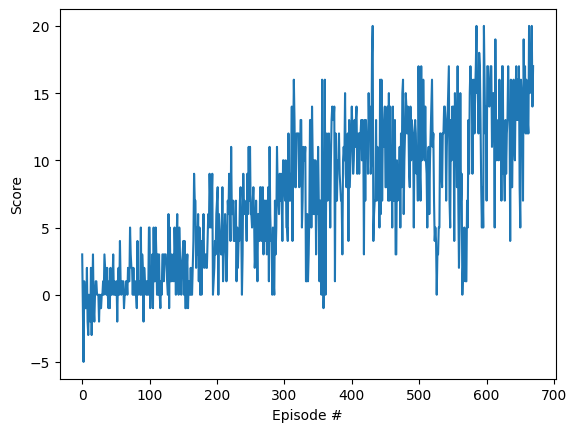

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('training_best.png')
plt.show()

**When finished, you can close the environment**

In [ ]:
env.close()